In [1]:
import os
import sys
import rootpath
sys.path.append(rootpath.detect())

from testsuite.utilities import Pareto_split
from testsuite.analysis import load_all #, plot_all_pareto_2d, PLOT_STYLE, plot_measure
from problem_setup import func, y, weighting, n_obj, n_dim

import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from testsuite import optimisers
from pymoo.factory import get_performance_indicator
from scipy.spatial import distance_matrix
from scipy.spatial.distance import cdist
import inspect

In [3]:
names = ['Mpoi', 'ParEgo', 'Saf_ei', 'Saf_$\\mu$', 'SmsEgo_ei', 'SmsEgo_$\\mu$', 'lhs']
true_names = ['MPoI', 'ParEGO', 'SAF: ei', 'SAF: $\mu$', 'SMS-EGO: ei', 'SMS-EGO: $\mu$', 'LHS']
D_names = {a:b for a, b in zip(names, true_names)}

In [4]:
# establish up data paths
try: 
    get_ipython().__class__.__name__
    script_dir = os.path.dirname(os.path.realpath(__file__))
except:
     script_dir = './'
results_dir = os.path.join(script_dir, "log_data/")
result_dirs = sorted(os.listdir(results_dir))

pkl_dir = os.path.join(script_dir, "pkl_data/")
pkl_filename = pkl_dir+'results_new.pkl'
if not os.path.isdir(pkl_dir):
    os.makedirs(pkl_dir)

In [5]:
OPTIMISER_NAMES = [cls[0].lower() for cls in inspect.getmembers(optimisers, inspect.isclass)
        if cls[1].__module__ == 'testsuite.optimisers']

In [6]:
def load_result(directory):
    result = load_all(directory, trailing_text = "_results.pkl")
    name = get_name_from_dir(directory)
    result['name'] = name
    return result

In [7]:
def get_name_from_dir(dir_string):
    bits = dir_string.split('_')
    name = [bit for bit in bits if bit.lower() in OPTIMISER_NAMES]

    if type(name) is list:
        name = name[0]
    if 'ei' in bits:
        name+='_ei'
    elif 'mean' in bits:
        name+='_$\mu$'
    return name


In [8]:
try:
    with open(pkl_filename,'rb') as infile:
        results = pickle.load(infile)
    print("results loaded from ", pkl_dir)
except FileNotFoundError:
    print("Failed to find results file in {}".format(pkl_filename))
    print("Results processing should be done first by running results_processing.py")
    
# assert len(results.keys()) == 7, "Not all optimisers present"
for key, value in results.items():
    print(key, " found")
    assert len(value['hypervolume']) == 31, \
    "not all hypervolumes for 31 repeats present for {}. Instead {} found.".format(key, len(value['hypervolume']))
    assert len(value['igd+']) == 31, \
    "not all igd+ for 31 repeats present for {}. Instead {} found.".format(key, len(value['hypervolume']))
    old_name = value['name']
    new_name = D_names[old_name]
    results[key]['name'] = new_name 
    print("name changed {} \t--->\t{}".format(old_name, new_name))

results loaded from  ./pkl_data/
Mpoi  found
name changed Mpoi 	--->	MPoI
ParEgo  found
name changed ParEgo 	--->	ParEGO
Saf_ei  found
name changed Saf_ei 	--->	SAF: ei
Saf_$\mu$  found
name changed Saf_$\mu$ 	--->	SAF: $\mu$
SmsEgo_ei  found
name changed SmsEgo_ei 	--->	SMS-EGO: ei
SmsEgo_$\mu$  found
name changed SmsEgo_$\mu$ 	--->	SMS-EGO: $\mu$
lhs  found
name changed lhs 	--->	LHS


In [12]:
new_r_dir = './log_data/'+os.getcwd().split("/")[-1].split("_")[0].upper()+'_SmsEgo_init10_MultiSurrogate/'
new_result = load_result(new_r_dir)
new_result['name'] = 'SmsEgo_new'
np.shape(new_result['y'])

(11, 250, 3)

In [13]:
old_r_dir = './log_data/'+os.getcwd().split("/")[-1].split("_")[0].upper()+'_SmsEgo_init10_MultiSurrogate_ei/'
old_result = load_result(old_r_dir)
old_result['name'] = 'SmsEgo_old'
np.shape(old_result['y'])

(31, 250, 3)

In [14]:
saf_r_dir = './log_data/'+os.getcwd().split("/")[-1].split("_")[0].upper()+'_Saf_init10_MultiSurrogate_mean/'
saf_result = load_result(saf_r_dir)
saf_result['name'] = 'SAF_mu'
np.shape(saf_result['y'])

(31, 250, 3)

In [15]:
ref_point = np.vstack((saf_result['y'], old_result['y'], new_result['y'])).reshape(-1,np.shape(new_result['y'])[-1]).max(axis=0)
ref_point

array([2.68732459, 4.53273484, 6.8510316 ])

In [16]:
p = np.load('/home/finley/phd/code/testsuite/experiments/igd_refpoints/data/wfg_elipse_3d_refpoints')

# set up ypervolume measure

# ref_point = np.round(p.max(axis=0), 1)*2

# setup measurement systems
hv_measure = get_performance_indicator("hv", ref_point=ref_point)
igdp_measure = get_performance_indicator("igd+", p)

In [17]:
from tqdm import tqdm
def extract_performance(y, indicator):
    performance = []
    for i in tqdm(range(9, len(y))):
        p = Pareto_split(y[:i])[0]
        ans = indicator.calc(p)
        performance.append(ans)
    return performance

In [18]:
y = np.array(new_result['y'])
hvs = np.zeros((y.shape[0], y.shape[1]))
igdps = np.zeros((y.shape[0], y.shape[1]))
for i, yi in enumerate(y):
    for j in tqdm(range(1, y.shape[1]+1)):
        hvs[i, j-1] = hv_measure.calc(yi[:j])
        igdps[i, j-1] = igdp_measure.calc(yi[:j])

new_result['hypervolume'] =  hvs
new_result['igd+'] = igdps

  4%|▎         | 9/250 [00:00<00:02, 85.90it/s]


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.configuration import Configuration
Configuration.show_compile_hint = False



100%|██████████| 250/250 [00:35<00:00,  7.14it/s]


In [19]:
y = np.array(old_result['y'][:11])
hvs = np.zeros((y.shape[0], y.shape[1]))
igdps = np.zeros((y.shape[0], y.shape[1]))
for i, yi in enumerate(y):
    for j in tqdm(range(1, y.shape[1]+1)):
        hvs[i, j-1] = hv_measure.calc(yi[:j])
        igdps[i, j-1] = igdp_measure.calc(yi[:j])

old_result['hypervolume'] =  hvs
old_result['igd+'] = igdps

100%|██████████| 250/250 [00:35<00:00,  7.10it/s]


In [20]:
y = np.array(saf_result['y'][:11])
hvs = np.zeros((y.shape[0], y.shape[1]))
igdps = np.zeros((y.shape[0], y.shape[1]))
for i, yi in enumerate(y):
    for j in tqdm(range(1, y.shape[1]+1)):
        hvs[i, j-1] = hv_measure.calc(yi[:j])
        igdps[i, j-1] = igdp_measure.calc(yi[:j])

saf_result['hypervolume'] =  hvs
saf_result['igd+'] = igdps

100%|██████████| 250/250 [00:34<00:00,  7.20it/s]


In [21]:
print(old_result['hypervolume'].shape)
print(saf_result['hypervolume'].shape)
print(new_result['hypervolume'].shape)

(11, 250)
(11, 250)
(11, 250)


In [22]:
phv = hv_measure.calc(p[::5])

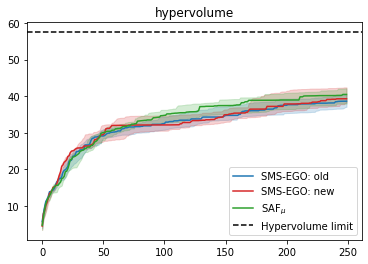

In [23]:
plt.figure()
plt.title("hypervolume")
plt.plot(range(0, 250), np.median(old_result['hypervolume'][:11], axis=0), c="C0", label="SMS-EGO: old") 
plt.fill_between(range(0, 250), np.percentile(old_result['hypervolume'][:11], 25, axis=0), np.percentile(old_result['hypervolume'][:11], 75, axis=0), color="C0", alpha=0.2)

plt.plot(range(0, 250), np.median(new_result['hypervolume'], axis=0), c="C3", label="SMS-EGO: new")  
plt.fill_between(range(0, 250), np.percentile(new_result['hypervolume'][:11], 25, axis=0), np.percentile(new_result['hypervolume'][:11], 75, axis=0), color="C3", alpha=0.2)

plt.plot(range(0, 250), np.median(saf_result['hypervolume'][:11], axis=0), c="C2", label="SAF$_\mu$")   
plt.fill_between(range(0, 250), np.percentile(saf_result['hypervolume'][:11], 25, axis=0), np.percentile(saf_result['hypervolume'][:11], 75, axis=0), color="C2", alpha=0.2)

plt.gca().axhline(phv, c="k", linestyle="--", label="Hypervolume limit")
plt.legend()

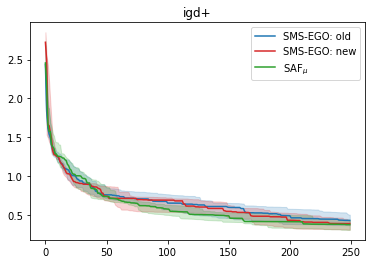

In [24]:
plt.figure()
plt.title("igd+")
plt.plot(range(0, 250), np.median(old_result['igd+'][:11], axis=0), c="C0", label="SMS-EGO: old") 
plt.fill_between(range(0, 250), np.percentile(old_result['igd+'][:11], 25, axis=0), np.percentile(old_result['igd+'][:11], 75, axis=0), color="C0", alpha=0.2)

plt.plot(range(0, 250), np.median(new_result['igd+'], axis=0), c="C3", label="SMS-EGO: new")  
plt.fill_between(range(0, 250), np.percentile(new_result['igd+'][:11], 25, axis=0), np.percentile(new_result['igd+'][:11], 75, axis=0), color="C3", alpha=0.2)

plt.plot(range(0, 250), np.median(saf_result['igd+'][:11], axis=0), c="C2", label="SAF$_\mu$")   
plt.fill_between(range(0, 250), np.percentile(saf_result['igd+'][:11], 25, axis=0), np.percentile(saf_result['igd+'][:11], 75, axis=0), color="C2", alpha=0.2)
plt.legend()

In [62]:
%matplotlib qt
fig = plt.figure(figsize=[10, 10])
ax = fig.gca(projection="3d")
ax.scatter(*p[::10].T, c="C3")